# **GCN модель для анализа поведения пользователей**

### Загрузка данных:
* Загружаются данные из CSV-файлов, включая информацию об узлах, рёбрах и ресурсах.
* Для узлов (пользователей) извлекаются такие признаки, как роль пользователя, количество логинов, уровень доступа и время с последнего входа.
* Для ресурсов вычисляются дополнительные признаки, такие как тип ресурса и уровень доступа.

In [408]:
import pandas as pd

# Пути к файлам
nodes_path = "data/nodes.csv"
resources_path = "data/resources.csv"
edges_path = "data/edges.csv"

# Загрузка данных
nodes_df = pd.read_csv(nodes_path)
resources_df = pd.read_csv(resources_path)
edges_df = pd.read_csv(edges_path, parse_dates=["timestamp"])

# Убедимся, что timestamp — это datetime
edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'], errors='coerce')


In [409]:
import numpy as np

# Параметры

start_hour = 9
end_hour = 18

offset = len(nodes_df)

# Определение нерабочего времени
edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'], errors='coerce')
edges_df['is_after_hours'] = (
    (edges_df['timestamp'].dt.hour < start_hour) |
    (edges_df['timestamp'].dt.hour >= end_hour) |
    (edges_df['timestamp'].dt.weekday >= 5)
)
after_hours_edges = set([
    (row['source_user'], row['target_resource'] + offset)
    for _, row in edges_df[edges_df['is_after_hours']].iterrows()
])


In [410]:
from sklearn.preprocessing import LabelEncoder
import torch

#IN_CHANNELS_MODEL = ['role_encoded', 'login_count', 'access_level', 'session_time', 'days_since_login']
IN_CHANNELS_MODEL = ['role_encoded', 'access_level']
#ADD_FEATURES = ['resource_type_encoded', 'importance', 'access_level']
ADD_FEATURES = ['resource_type_encoded', 'importance']

# Кодирование признаков узлов
role_encoder = LabelEncoder()
nodes_df['role_encoded'] = role_encoder.fit_transform(nodes_df['role'])
# Признаки Время последнего входа → дни
nodes_df['last_login_time'] = pd.to_datetime(nodes_df['last_login_time'])
ref_date = pd.Timestamp("2025-05-18")
nodes_df['days_since_login'] = (ref_date - nodes_df['last_login_time']).dt.days
# Признаки пользователей
user_features = nodes_df[IN_CHANNELS_MODEL].values

In [411]:
# Кодирование признаков узлов (ресурсы)
resource_encoder = LabelEncoder()
# Обработка ресурсов
resources_df['resource_type_encoded'] = resource_encoder.fit_transform(resources_df['resource_type'])
# Реальные признаки ресурсов
base_resource_features = resources_df[ADD_FEATURES].values
# Дополняем признаки ресурсов двумя нулями (чтобы было 6 признаков, как у пользователей)
#resource_features_padded = np.hstack([base_resource_features, np.zeros((base_resource_features.shape[0], 3))])
resource_features_padded = np.hstack([base_resource_features, np.zeros((base_resource_features.shape[0], user_features.shape[1]-base_resource_features.shape[1]))])
# Объединяем признаки пользователей и ресурсов
x_combined = np.vstack([user_features, resource_features_padded])

In [412]:
# Cоздается тензор (многомерный массив) из данных x_combined
# Этот тензор x будет использоваться как входные данные для GCN (Graph Convolutional Network) части модели
x = torch.tensor(x_combined, dtype=torch.float)

In [413]:
# Переменная offset будет использоваться для корректной индексации узлов-ресурсов
#offset = len(user_features)
# Извлекаем столбец source_user из DataFrame edges_df (источники рёбер - пользователи), преобразуем значения в целые числа и получает NumPy массив
sources = edges_df['source_user'].astype(int).values
# Извлекаем столбец target_resource (цели рёбер - ресурсы), преобразуем в целые числа и получает NumPy массив
targets = edges_df['target_resource'].astype(int).values + offset
# Объединяем в edge_index [2, num_edges]
edge_index_np = np.vstack([sources, targets])
edge_index = torch.tensor(edge_index_np, dtype=torch.long)

In [414]:
y = torch.tensor(nodes_df['role_encoded'].values, dtype=torch.long)

In [415]:
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, y=y)

In [416]:
num_users = y.shape[0]
# Обучающая маска — используем только узлы-пользователи.
# Только пользователи имеют известные метки (y).
# Ресурсы — это объекты взаимодействия, и они участвуют в обучении опосредованно через связи (рёбра), но не обучаются напрямую как целевые точки.
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:num_users] = True

In [417]:
# Добавим фиктивные метки для ресурсов
num_resources = resource_features_padded.shape[0]
y_full = np.concatenate([y, -1 * np.ones(num_resources)])  # -1 — метка для нерелевантных узлов

# Сконвертируем
data.y = torch.tensor(y_full, dtype=torch.long)

## Загрузка и подготовка тестовых данных GCN

In [418]:
# === Загрузка тестовых данных ===
nodes_test = pd.read_csv("data/nodes_test.csv")
edges_test = pd.read_csv("data/edges_test.csv")
resources_test = pd.read_csv("data/resources_test.csv")

edges_test['timestamp'] = pd.to_datetime(edges_test['timestamp'], errors='coerce')
# Кодирование признаков узлов
nodes_test['role_encoded'] = role_encoder.transform(nodes_test['role'])
# Признаки Время последнего входа → дни
nodes_test['last_login_time'] = pd.to_datetime(nodes_test['last_login_time'])
nodes_test['days_since_login'] = (ref_date - nodes_test['last_login_time']).dt.days
# Признаки пользователей
#x_test_users = nodes_test[['role_encoded', 'login_count', 'access_level', 'session_time', 'var_activity', 'days_since_login']].to_numpy()
x_test_users = nodes_test[IN_CHANNELS_MODEL].to_numpy()
# Обработка ресурсов ---
resources_test['resource_type_encoded'] = resource_encoder.transform(resources_test['resource_type'])
# Реальные признаки ресурсов
x_test_resources = resources_test[ADD_FEATURES].to_numpy()
# Дополняем признаки ресурсов двумя нулями (чтобы было 6 признаков, как у пользователей)
x_test_resources_padded = np.hstack([x_test_resources, np.zeros((x_test_resources.shape[0], x_test_users.shape[1] - x_test_resources.shape[1]))])

#num_users_test = x_test_users.shape[0]
#num_resources_test = x_test_resources.shape[0]
#x_test_resources_padded = np.zeros((num_resources_test, x_test_users.shape[1]))

# Объединяем признаки пользователей и ресурсов
x_test_combined = np.vstack([x_test_users, x_test_resources_padded])
num_test_users = x_test_users.shape[0]
sources_test = edges_test['source_user'].astype(int).values
targets_test = edges_test['target_resource'].astype(int).values + offset
edge_index_test_np = np.vstack([sources_test, targets_test])
edge_index_test = torch.tensor(edge_index_test_np, dtype=torch.long)

test_data = Data(x=torch.tensor(x_test_combined, dtype=torch.float), edge_index=edge_index_test)

## Подготовка данных для модели LSTM

In [419]:
# === LSTM часть: последовательности действий ===
edges_df = edges_df.dropna(subset=['event_type'])
edges_df['event_type_id'] = LabelEncoder().fit_transform(edges_df['event_type'])
edges_df['hour'] = edges_df['timestamp'].dt.hour
edges_df['dayofweek'] = edges_df['timestamp'].dt.dayofweek

features = ['hour', 'dayofweek', 'event_type_id', 'weight']
sequences = []
user_ids = sorted(edges_df['source_user'].unique())

for user_id in user_ids:
    user_seq = edges_df[edges_df['source_user'] == user_id].sort_values('timestamp')[features].values
    sequences.append(user_seq)

max_len = max(len(seq) for seq in sequences)
num_features = len(features)
padded = np.zeros((len(sequences), max_len, num_features))
for i, seq in enumerate(sequences):
    padded[i, :len(seq), :] = seq

lstm_input_tensor = torch.tensor(padded, dtype=torch.float)

In [420]:
lstm_input_tensor

tensor([[[12.0000,  2.0000,  0.0000,  0.7247],
         [12.0000,  0.0000,  2.0000,  0.7197],
         [12.0000,  3.0000,  1.0000,  0.7318],
         [12.0000,  1.0000,  2.0000,  0.9497],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[14.0000,  4.0000,  2.0000,  0.5116],
         [14.0000,  0.0000,  1.0000,  0.9335],
         [14.0000,  1.0000,  0.0000,  0.6225],
         [14.0000,  0.0000,  1.0000,  0.5443],
         [14.0000,  0.0000,  2.0000,  0.5342],
         [14.0000,  3.0000,  1.0000,  0.9405],
         [14.0000,  2.0000,  1.0000,  0.9735],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[15.0000,  0.0000,  2.0000,  0.4614],
         [15.0000,  3.0000,  2.0000,  0.2665],
         [18.0000,  0.0000,  2.0000,  0.7581],
         

## Модель GCN

In [421]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# --- Модель GCN ---
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)


## Гибридная модель

In [422]:
import torch.nn as nn

# === Гибридная модель ===
class HybridModel(nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim):
        super().__init__()
        # GCN часть
        self.gcn1 = GCNConv(num_node_features, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)

        # LSTM для обработки временных меток
        self.lstm = nn.LSTM(input_size=num_edge_features+1,  # +1 потому что добавлен один признак ресурса
                           hidden_size=hidden_dim,
                           batch_first=True)
        # Классификатор
        self.fc = nn.Linear(hidden_dim * 2, 2)  # Умножаем на 2, так как объединяем GCN и LSTM выходы

    def forward(self, data):
        # Обработка графа
        x = F.relu(self.gcn1(data.x, data.edge_index))
        x_gcn = self.gcn2(x, data.edge_index)  # [num_nodes, hidden_dim]

        # Обработка временных признаков
        edge_attr = data.edge_attr.unsqueeze(0)  # [1, num_edges, num_edge_features]
        _, (h_n, _) = self.lstm(edge_attr)
        lstm_out = h_n.squeeze(0)  # [1, hidden_dim]

        # Применяем GCN признаки к каждому узлу
        gcn_out = x_gcn  # [num_nodes, hidden_dim]

        # Повторяем LSTM выход для каждого узла
        lstm_repeated = lstm_out.repeat(gcn_out.size(0), 1)  # [num_nodes, hidden_dim]

        # Объединение признаков
        combined = torch.cat([gcn_out, lstm_repeated], dim=1)  # [num_nodes, hidden_dim * 2]

        return F.log_softmax(self.fc(combined), dim=1)

## Обучение

In [423]:
# Обучение
class Trainer:
    def __init__(self, model, data, optimizer, criterion):
        self.model = model
        self.data = data
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, lstm_input_tr=None):
        self.model.train()
        self.optimizer.zero_grad()

        if lstm_input_tr is not None:
            out = self.model(self.data, lstm_input_tr)  # Для GCN+LSTM
        else:
            out = self.model(self.data)  # Только GCN

        loss = self.criterion(out[self.data.train_mask], self.data.y[self.data.train_mask])
        loss.backward()
        self.optimizer.step()
        return loss.item()


## Предсказание на новых данных

In [424]:
# === Предсказание на новых данных ===
class Tester:
    def __init__(self, model, test_data, y, num_test_users):
        """
        model: обученная модель (GCN или GCN+LSTM)
        test_data: данные в формате PyTorch Geometric Data
        y: истинные метки классов (тензор)
        num_test_users: количество узлов-пользователей в тестовой выборке
        """
        self.model = model
        self.test_data = test_data
        self.y = y
        self.num_test_users = num_test_users

    def test(self, lstm_input_tr=None):
        self.model.eval()

        with torch.no_grad():
            if lstm_input_tr is not None:
                out = self.model(self.test_data, lstm_input_tr)
            else:
                out = self.model(self.test_data)

            preds = out.argmax(dim=1)
            test_preds = preds[:self.num_test_users]
            correct = (test_preds == self.y[:self.num_test_users]).sum()
            acc = int(correct) / int(len(test_preds))

        return acc


In [425]:
GCN_HIDDEN_CHANNELS = 40
LSTM_HIDDEN_CHANNELS = 40
MAX_EPOCHS = 101
GCN_IN_CHANNELS = x.shape[1]
LSTM_IN_CHANNELS = 4


# Инициализация и обучение
model = GCN(in_channels=GCN_IN_CHANNELS, hidden_channels=GCN_HIDDEN_CHANNELS, out_channels=len(torch.unique(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [426]:
trainer = Trainer(model, data, optimizer, criterion)

In [427]:
tester = Tester(model, test_data, y, num_test_users)

In [428]:
losses_gcn = []
losses_gcn_lstm = []
accuracies_gcn = []
accuracies_gcn_lstm = []
for epoch in range(1, MAX_EPOCHS):

    loss_gcn = trainer.train()
    #loss_gcn_lstm = trainer.train(lstm_input_tensor)
    losses_gcn.append(loss_gcn)
    #losses_gcn_lstm.append(loss_gcn_lstm)

    acc_gcn = tester.test()
    accuracies_gcn.append(acc_gcn)
    #acc_gcn_lstm = tester.test(lstm_input_tensor)
    #accuracies_gcn_lstm.append(acc_gcn_lstm)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Эпоха {epoch:03d}, Потери: {loss_gcn:.4f}, Тестирование (Точность): {acc_gcn:.4f}")


TypeError: GCN.forward() takes 2 positional arguments but 3 were given

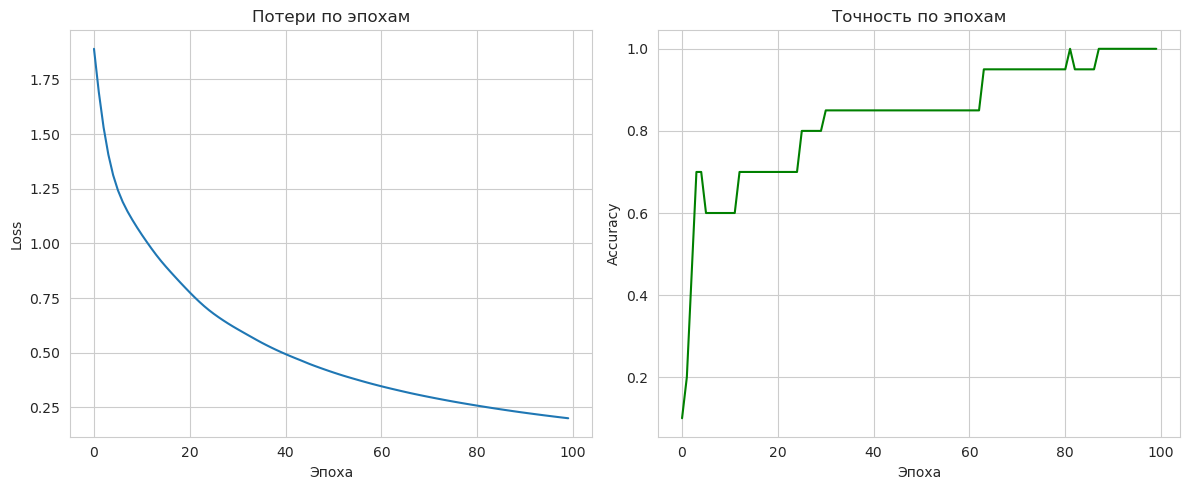

In [407]:
#Визуализация обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_gcn, label='Loss')
plt.title("Потери по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies_gcn, label='Accuracy', color='green')
plt.title("Точность по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()